# Задание

1) Попробовать несколько различных [техник нормализации](http://yeephycho.github.io/2016/08/03/normalizations_in_neural_networks/) изображения (дополнительная информация: [1](https://medium.com/@dibyadas/visualizing-different-normalization-techniques-84ea5cc8c378), [2](https://github.com/dibyadas/Visualize-Normalizations)). (2 балла)

    a) без нормализации

    b) Local Contrast Normalization

    c) Local Responce Normalization
2) Попробовать применить [аугментацию](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py) (как минимум 3 варианта). Как она влияет на процесс обучения? (2 балла)

    a) Horizontal flip

    b) Color augmentation

    c) Affine (любой)

    d) [MixUp](https://towardsdatascience.com/yolov7-a-deep-dive-into-the-current-state-of-the-art-for-object-detection-ce3ffedeeaeb)

    e) Mosaic
3) Возьмите любую модель, с которой вы хотите провести эти эксперименты, и постарайтесь набрать как можно больше очков. (3 балла)
4) Напишите свою собственную модель и обучите ее. Отправьте submission (результаты в таблице лидеров для hand-made моделей будут сравниваться отдельно). (3 балла)
5) (опционально) Попробуйте проанализировать ошибки модели, чтобы узнать, как повысить метрики. (3 балла)

## Описание датасета

Набор данных разделен на тренировочные/тестовые данные (12k/3k). Формат аннотаций — COCO, поэтому для оценки модели будут использоваться скрипты coco_eval.

Структура аннотационного файла:

* info - основная информация про датасет
* licenses - лицензия (All data is under MIT license.)
* categories - секция с описание классов (она также содержит id2categ mapping)
* images - список изображений, использованных в датасете (подмножество от оригинального датасета)
* annotations - список аннотаций к изображениям

Данный датасет — уменьшенная версия [Udacity Self Driving Car Dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) с уточнёнными метками, так как в оригинальном датасете могут отсутствовать метки для тысяч пешеходов, байкеров, автомобилей и светофоров (что приводит к ухудшению производительности модели).

Некоторые примеры меток, отсутствующих в исходном наборе данных:
![Примеры отсутствующих ярлыков](https://i.imgur.com/A5J3qSt.jpg)

Датасет содержит 97,942 меток из 11 возможных классов, в совокупности — 15,000 изображений. Кроме того, в нём присутствует 1,720 изображений без меток (null examples).

Рассматривается версия датасета, в котором все изображения имеют формат 512x512 пикселей (размер ~580 MB), так как она подходит для большинства распространенных моделей машинного обучения (включая YOLO v3, Mask R-CNN, SSD, и mobilenet).

## Настройки/Гиперпараметры/Импорты

In [6]:
# import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install scikit-image

# !pip install --upgrade torch==1.9.0
# !pip install --upgrade torchvision==0.10.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 24.5/24.5 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 313.3/313.3 kB 1.8 MB/s eta 0:00:00
     -------------------------------------- 222.9/222.9 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: lazy_loader
    Found existing installation: lazy_loader 0.2
    Uninstalling lazy_loader-0.2:
      Successfully uninstalled lazy_loader-0.2


In [1]:
import json # для считывания файла с описание данных/датасета
import numpy as np # для быстрой работы с массивами
import pickle # для сохранения файлов
import os # для обращение к папкам и файлам

from tqdm import tqdm # для отслеживания прогресса циклов

# from PIL import Image # для открытия и работы с изображениями
# import transforms as T # для преобразования изображения в тензор и различных манипуляций с ними (поворот...)

import cv2 # для работы с изображениями (LCN нормализация)
import skimage.exposure # для восстановления изображения из изменённых значения цветов пикселей (после нормализации, деления и т.д.)

import torch # для работы с тензорами
import torchvision
from torchvision.io import read_image # для считывания изображения
from torchvision import transforms # для преобразования изображения в тензор и различных манипуляций с ними (поворот...)
from torchvision.utils import draw_bounding_boxes # для построения bounding box-ов

In [2]:
device_id = -1 # -1 для cpu, >=0 для cuda
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # на коком устройстве будет выполняться код

test_size = 0.2 # размер датасета для тестирования
random_state = 42 # случайное значение для генераций

k_size_norm = 5 # размер ядра для нормализации

normalization_vars = ["none", "LCN", "LRN"] # варианты нормализации изображения
augmentation_vars = ["horizontal", "color", "affine", "mixup", "mosaic"] # варианты аугментации изображений

### Вспомогательные функции

In [3]:
def convert_bbox(bboxes): # функция конвертирует bbox из формата (xmin, ymin, width, height) в (xmin, ymin, xmax, ymax) ~ (левый нижний угол, правый верхний угол)
    bboxes_converted = torch.zeros(size=(len(bboxes), 4), dtype=torch.int16) # заготовка под bbox-ы (torch.int16 для координат на изображении 512x512)
    for i, bbox in enumerate(bboxes): # идём по пришедшим bbox-ам
        bboxes_converted[i][0] = bbox[0] # задаём координату xmin
        bboxes_converted[i][1] = bbox[1] # задаём координату ymin
        bboxes_converted[i][2] = bbox[0] + bbox[2] # задаём координату xmax
        bboxes_converted[i][3] = bbox[1] + bbox[3] # задаём координату ymax
    return bboxes_converted

In [4]:
def print_image(image, bboxes, labels=None, colors=None, fill=False): # функция для вывода изображения с bounding box-ами
    if isinstance(image, str): # проверяем, если переданный image - строка (путь до файла)
        image = read_image(f"data/train_images/{image}") # открываем изображение (RGB тензор 3x512x512)
    # если image уже передан как тензор, то функция отработает гораздо быстрее

    bboxes = convert_bbox(bboxes) # конвертируем bbox в (xmin, ymin, xmax, ymax)

    image = draw_bounding_boxes(
        image=image, # оригинальное изображение
        boxes=bboxes, # Tensor размера (N, 4), где N - число bb, 4 - координаты для левого нижнего и правого верхнего угла
        width=2, # ширина bb
        labels=labels, # список названий меток для bb (например ["name"] * len(bboxes))
        # colors=[(255,255,0)] * len(bbox), # список цветов для bb
        colors=colors, # список цветов для bb (например [(255,255,0)] * len(bboxes))
        fill=fill, # заливать ли внутренности bb
        )
    
    image = transforms.ToPILImage()(image) # конвертируем тензор в PILImage
    # вызов странный, так как transforms.ToPILImage() - создаёт класс, (image) вызывает метод __call__ у этого класса
    display(image)
    # image.show() # вывод изображения (в новом окне)

In [5]:
def change_shape(image): # из (channels, width, height) в (width, height, channels), так как библиотека cv2 работает с форматом (width, height, channels)
    if image.shape[0] == 3: # первый канал — RGB цвета
        image_reshaped = np.zeros(shape=(image.shape[1], image.shape[2], image.shape[0]), dtype=np.uint8) # заготавливаем массив для изменения
        for channel in range(image.shape[0]): # идём по каналам
            for width in range(image.shape[1]):
                for height in range(image.shape[2]):
                    image_reshaped[width][height][channel] = image[channel][width][height]
    else: # если первый канал не цвета
        image_reshaped = np.zeros(shape=(image.shape[2], image.shape[0], image.shape[1]), dtype=np.uint8)
        for width in range(image.shape[0]): # идём по каналам
            for height in range(image.shape[1]):
                for channel in range(image.shape[2]):
                    image_reshaped[channel][width][height] = image[width][height][channel]
    return image_reshaped

## 0) Подготовка данных

### Аннотация

In [6]:
with open('data/usdc_train.json') as f: # открываем файл-аннотацию для картинок
    data = json.load(f) # считываем данные из него
data.keys() # вывод ключей ключи в аннотации

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [7]:
# data["images"] - базовая информация о картинке, например:
#  ..., {
#   'id': 5439, - номер изображения
#   'license': 1, - лицензия
#   'file_name': '1478732060018477118_jpg.rf.4Zb2Pcilfk0Xgp04Z2AS.jpg', - имя файла
#   'height': 512, - высота (число пикселей по оси Y)
#   'width': 512, - ширина (число пикселей по оси X)
#   'date_captured': '2021-06-09T12:24:25+00:00' - дата съёмки
#  }, ...

# data["annotations"] — подробные данные о картинке и её метках, например:
#  ..., {
#   'id': 4368, - номер аннотации
#   'image_id': 677, - номер соответствующего изображения
#   'category_id': 2, - тип метки
#   'bbox': [327, 241, 27.733333333333334, 23.040000000000003], - bounding box объекта (x, y, width, height)
#   'area': 638.9760000000001, - покрываемая область (в пикселя)
#   'segmentation': [], — ?
#   'iscrowd': 0, — много ли объектов (crowd - толпа)
#   'confidence': 0.5, — уверенность модели в предсказании
#   'score': 0.5 — оценка правильности предсказания (mAP)
#  }, ...

data["categories"] # возможные метки на изображениях

[{'id': 0, 'name': 'obstacles', 'supercategory': 'none'},
 {'id': 1, 'name': 'biker', 'supercategory': 'obstacles'},
 {'id': 2, 'name': 'car', 'supercategory': 'obstacles'},
 {'id': 3, 'name': 'pedestrian', 'supercategory': 'obstacles'},
 {'id': 4, 'name': 'trafficLight', 'supercategory': 'obstacles'},
 {'id': 5, 'name': 'trafficLight-Green', 'supercategory': 'obstacles'},
 {'id': 6, 'name': 'trafficLight-GreenLeft', 'supercategory': 'obstacles'},
 {'id': 7, 'name': 'trafficLight-Red', 'supercategory': 'obstacles'},
 {'id': 8, 'name': 'trafficLight-RedLeft', 'supercategory': 'obstacles'},
 {'id': 9, 'name': 'trafficLight-Yellow', 'supercategory': 'obstacles'},
 {'id': 10, 'name': 'trafficLight-YellowLeft', 'supercategory': 'obstacles'},
 {'id': 11, 'name': 'truck', 'supercategory': 'obstacles'}]

In [8]:
data_train = {} # заготавливаем словарь (так как id у картинок не с нуля до 11999) под данные о картинка {номер картинки: [путь до картинки, [метки], [bounding box-ы для меток]]

for image in data["images"]: # идём по картинкам
    data_train[image["id"]] = [image["file_name"], [], []] # добавляем путь до изображения и заготовливаем место под метки и bb

for anotation in data["annotations"]: # идём по аннотациям
    data_train[anotation["image_id"]][1].append(anotation["category_id"]) # добавляем метку
    data_train[anotation["image_id"]][2].append(anotation["bbox"]) # добавляем bounding box

### Пример работы с изображениями

In [15]:
data_train[666] # вывод данных о картинке под номером 666(число зверя)

['1478732936875235392_jpg.rf.6rjDFEsPbNxJmuwgkyzo.jpg',
 [2, 2, 2, 2, 2, 2, 2, 2],
 [[418, 177, 93.86666666666666, 232.96],
  [0, 230, 40, 99.84],
  [127, 242, 40.53333333333333, 52.053333333333335],
  [166, 244, 20.266666666666666, 35.84],
  [306, 241, 12.266666666666666, 46.93333333333334],
  [317, 227, 19.733333333333334, 73.38666666666667],
  [334, 230, 14.933333333333334, 76.80000000000001],
  [339, 202, 85.86666666666666, 142.5066666666667]]]

In [16]:
image = read_image(f"data/train_images/{data_train[666][0]}") # открытие картинки (mode=default, картинка открывается как есть и конвертируется в int8 тензор)
image

tensor([[[138, 125, 113,  ..., 145, 145, 145],
         [125, 120, 114,  ..., 146, 145, 145],
         [115, 117, 118,  ..., 146, 146, 145],
         ...,
         [ 23,  23,  23,  ...,  20,  20,  20],
         [ 23,  23,  23,  ...,  20,  20,  20],
         [ 23,  23,  23,  ...,  20,  20,  20]],

        [[148, 135, 123,  ..., 155, 155, 155],
         [135, 130, 124,  ..., 156, 155, 155],
         [125, 127, 128,  ..., 156, 156, 155],
         ...,
         [ 18,  18,  18,  ...,  18,  18,  18],
         [ 18,  18,  18,  ...,  18,  18,  18],
         [ 18,  18,  18,  ...,  18,  18,  18]],

        [[160, 147, 135,  ..., 167, 167, 167],
         [147, 142, 136,  ..., 168, 167, 167],
         [137, 139, 140,  ..., 168, 168, 167],
         ...,
         [ 14,  14,  14,  ...,  19,  19,  19],
         [ 14,  14,  14,  ...,  19,  19,  19],
         [ 14,  14,  14,  ...,  19,  19,  19]]], dtype=torch.uint8)

In [17]:
data_train[666][2] # bounding box-ы для этого изображения в формате (xmin, ymin, width, height)

[[418, 177, 93.86666666666666, 232.96],
 [0, 230, 40, 99.84],
 [127, 242, 40.53333333333333, 52.053333333333335],
 [166, 244, 20.266666666666666, 35.84],
 [306, 241, 12.266666666666666, 46.93333333333334],
 [317, 227, 19.733333333333334, 73.38666666666667],
 [334, 230, 14.933333333333334, 76.80000000000001],
 [339, 202, 85.86666666666666, 142.5066666666667]]

In [18]:
convert_bbox(data_train[666][2]) # сконвертированные bb в формат (xmin, ymin, xmax, ymax)

tensor([[418, 177, 511, 409],
        [  0, 230,  40, 329],
        [127, 242, 167, 294],
        [166, 244, 186, 279],
        [306, 241, 318, 287],
        [317, 227, 336, 300],
        [334, 230, 348, 306],
        [339, 202, 424, 344]], dtype=torch.int16)

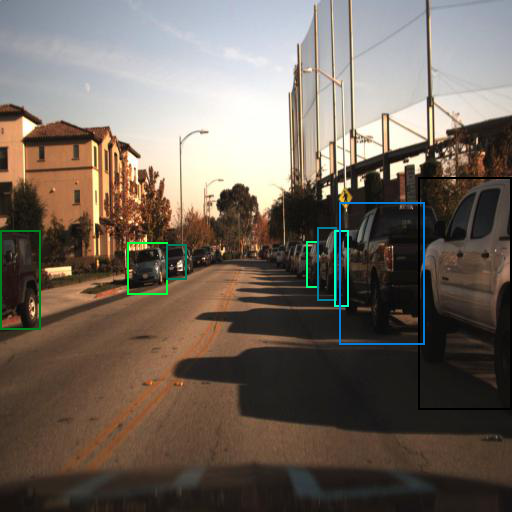

In [34]:
print_image(data_train[666][0], data_train[666][2])

## 1) Нормализация изображений

### LCN

**LCN — Local Contrast Normalization**

In this, there is a competition between a pixel and it’s locality of a given radius. It’s original paper used a radius of 9. A kernel of 9x9, whose weights are Gaussian of mean 0 and variance 1, is convolved on the image across the channels. After centering the image (by subtracting the above output from the image), it’s variance is determined. Then, the mean of standard deviations of all the pixels is found. After which, the centered image is divided by max(standard_deviation, mean_standard_deviation) to get the LCN_Image.

In [35]:
# img = cv2.imread(f"data/train_images/{data_train[666][0]}")
image_ = np.array(change_shape(image)) # преобразуем изображение в формат (width, height, channels), так как с ним работает библиотека cv2 в np.array

mean = cv2.GaussianBlur(src=image_, ksize=(k_size_norm, k_size_norm), sigmaX=0, sigmaY=0) # заблюренное изображение с использованием распределения Гаусса (нормальное распределение с ожиданием 0 и дисперсией 1) (получается серым)
# веса в ядре — чем ближе к середине, тем больше вес (см gaussian filter статьи для лучшего объяснения) 
# src - исходное изображение
# ksize - размер ядра фильтра (если (0,0) — то оно строиться по sigmaX и sigmaY; если sigmaX и sigmaY нули, то они определяются по ksize)
# sigmaX — стандартное отклонение (standard deviation) ядра по оси X (горизонтальное направление)
# sigmaY — стандартное отклонение (standard deviation) ядра по оси Y (вертикальное направление)

median = cv2.medianBlur(src=mean, ksize=k_size_norm**2) # применение медианного фильтра к изображению (в ядре фильтра веса 1/размер ядра) - общее заблюривание
# src - исходное изображение
# ksize - размер ядра фильтра

division = cv2.divide(mean/255, median/255) # делим средее на медиану (поэлементное деление)

std = np.std(division) # получение глобального стандартного отклонения деления

image_ = division/std # разделяем все элементы division на значение стандартного отклонения
image_ = skimage.exposure.rescale_intensity(image=image_, in_range='image', out_range=(0,255)).astype(np.uint8) # возвращаем значения обратно в область от 0 до 255 (цвета в RGM)
# image - преобразованное изображение
# in_range — минимальное и максимальное значение в изображении на входе (если = 'image', то они возьмутся из переданного изображения)
# out_range — минимальное и максимальное значение, в которые надо преобразовать
# .astype(np.uint8) - преобразование к типу np.uint8

image_ = torch.tensor(change_shape(image_)) # возвращаем данные в формат (channels, width, height) и делаем обратно тензор

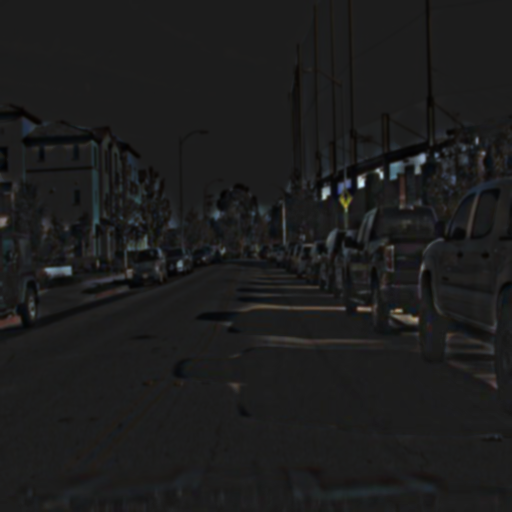

In [37]:
display(transforms.ToPILImage()(image_)) # пример при ядре 5 в GaussianBlur (25 в medianBlur)

### LRN

**LRN — Local Response Normalization**

This is similar to LCN in the way that it tries to introduce competition between the pixels but differs in the way that the competition occurs between the adjacent convolution outputs. It’s explained very well in the article and I recommend you to go through it.

In [163]:
a = torch.randn(32, 5, 24, 24)

In [175]:
image[2][0][0]

tensor(160, dtype=torch.uint8)

In [177]:
image.reshape((1,3,512,512))[0][2][0][0]

tensor(160, dtype=torch.uint8)

In [169]:
lrn = torch.nn.LocalResponseNorm(2)
lrn()

tensor([[[[ 3.9644e-01,  1.3289e+00,  8.8441e-01,  ...,  1.9239e+00,
           -6.2406e-03, -8.8569e-01],
          [ 4.3482e-01, -6.1875e-01, -1.4714e+00,  ..., -6.0998e-01,
            5.3055e-01, -4.1567e-01],
          [ 6.0244e-01, -1.3664e+00, -1.9542e+00,  ..., -3.9740e-01,
           -1.1928e+00, -3.9455e-01],
          ...,
          [ 1.2689e+00, -1.7303e-02, -4.7472e-01,  ..., -1.3262e+00,
           -1.2042e+00, -2.8432e-02],
          [-8.0262e-01,  8.2535e-01,  1.0961e+00,  ..., -1.1392e+00,
            2.8119e-01,  7.8998e-01],
          [-6.1003e-01,  3.1685e-01,  1.5987e+00,  ..., -2.3187e-01,
            2.3501e-02,  4.8442e-01]],

         [[-1.4115e+00, -9.0771e-01,  6.2970e-01,  ..., -7.8396e-01,
           -1.1681e+00, -1.5395e-01],
          [-7.2598e-01,  1.1365e+00,  1.2252e-01,  ..., -1.3686e+00,
            7.5074e-01, -9.6542e-01],
          [-7.3442e-02,  7.6744e-02,  4.0999e-01,  ...,  1.1180e+00,
            8.1929e-01,  4.9468e-01],
          ...,
     

### Использование всех трёх вариантов нормализации (без нормализации, LCN, LRN) на картинках

In [9]:
normalization_vars=["none", "LCN"]

In [10]:
images = {} # словарь для сохранения всех изображений {путь_до_изображений: трёхканальное_изображение_512x512}
for img_n in tqdm(data_train.keys()): # идём по номерам картинок (ключам словаря)
    images[data_train[img_n][0]] = read_image(f"data/train_images/{data_train[img_n][0]}") # загружаем все изображения (~9 Гб оперативной памяти)

100%|██████████| 12000/12000 [05:12<00:00, 38.43it/s]


In [12]:
for img_path in tqdm(images.keys()): # идём по путям изображений (ключам словаря)
    for var1 in normalization_vars: # идём по вариантам нормализации
        if os.path.exists(f"data/normalized/{var1}/{img_path}"): # если такая нормализация уже была проведена — переходим к следующему варианту/изображению
            continue

        if var1 == "LCN": # нормализация — Local Contrast Normalization
            image_ = np.array(change_shape(images[img_path])) # преобразуем изображение в формат (width, height, channels), так как с ним работает библиотека cv2 в np.array

            mean = cv2.GaussianBlur(src=image_, ksize=(k_size_norm, k_size_norm), sigmaX=0, sigmaY=0) # заблюренное изображение с использованием распределения Гаусса (нормальное распределение с ожиданием 0 и дисперсией 1) (получается серым)
            # веса в ядре — чем ближе к середине, тем больше вес (см gaussian filter статьи для лучшего объяснения) 
            # src - исходное изображение
            # ksize - размер ядра фильтра (если (0,0) — то оно строиться по sigmaX и sigmaY; если sigmaX и sigmaY нули, то они определяются по ksize)
            # sigmaX — стандартное отклонение (standard deviation) ядра по оси X (горизонтальное направление)
            # sigmaY — стандартное отклонение (standard deviation) ядра по оси Y (вертикальное направление)

            median = cv2.medianBlur(src=mean, ksize=k_size_norm**2) # применение медианного фильтра к изображению (в ядре фильтра веса 1/размер ядра) - общее заблюривание
            # src - исходное изображение
            # ksize - размер ядра фильтра

            division = cv2.divide(mean/255, median/255) # делим средее на медиану (поэлементное деление)

            std = np.std(division) # получение глобального стандартного отклонения деления

            image_ = division/std # разделяем все элементы division на значение стандартного отклонения
            image_ = skimage.exposure.rescale_intensity(image=image_, in_range='image', out_range=(0,255)).astype(np.uint8) # возвращаем значения обратно в область от 0 до 255 (цвета в RGM)
            # image - преобразованное изображение
            # in_range — минимальное и максимальное значение в изображении на входе (если = 'image', то они возьмутся из переданного изображения)
            # out_range — минимальное и максимальное значение, в которые надо преобразовать
            # .astype(np.uint8) - преобразование к типу np.uint8

            image_ = torch.tensor(change_shape(image_)) # возвращаем данные в формат (channels, width, height) и делаем обратно тензор
        # if var1 == "LRN": # нормализация — Local Responce Normalization
            
        if var1 == "none": # если вариант нормализации - "none", просто сохраняем картинку в новую папку
            image_ = images[img_path]
        transforms.ToPILImage()(image_).save(f"data/normalized/{var1}/{img_path}") # сохраняем обработанную картинку
        # with open(f"data/normalized/{var1}/{data_train[img_n][0]}", 'wb') as f: # открытие файла для записи (b - бинарной)
        #     pickle.dump(image_, f)
        

  0%|          | 4/12000 [00:00<05:18, 37.61it/s]

 21%|██        | 2481/12000 [4:46:34<18:19:33,  6.93s/it]


KeyboardInterrupt: 

## 2) Аугментация изображений

In [ ]:
for var1 in normalization_vars: # идём по вариантам нормализации
    for var2 in augmentation_vars: # идём по вариантам аугментации
        if var2 == "horizontal": # если аугментация — горизонтальный поворот
            image2 = transforms.RandomHorizontalFlip(1)(image)

## 3) Обучение модели

In [ ]:
# transforms.ToPILImage()(image)
transforms.ToTensor()(transforms.ToPILImage()(image))

### Заготавливаем датасет

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset): # кастомный датасет
    def __init__(self, data_dir, transforms=None, annotation_path=None): # конструктор датасет
        self.data_dir = data_dir # путь до папки с изображениями
        self.data = os.listdir(data_dir) # список всех файлов картинок (список строк путей из папки data_dir)
        if annotation_path: # путь до файла с аннотацией
        self.transforms = transforms # функции для преобразования изображения

    def __len__(self): # возвращает число элементов в датасете
        return len(self.img_labels)
    
    def __getitem__(self, idx): # возвращает изображение по индексу
        
        image = read_image(img_path)

        if self.transforms: # трансформируем изображение, если надо
            image = self.transforms(image)
        return image, target

### Обучаем модель

## 4) Реализация собственной модели

## 5) Анализ ошибок